## Astro 330 "Computational Astrophysics"

### Homework 5. Statistical inference using MCMC (40 points)

### Distributed 9 November; due Wednesday, Nov 16, 7pm. 

In [2]:
from __future__ import division
from math import cos
import numpy as np
from time import time
from time import clock
import string
import sys
import time
import pandas
from codes.plot_utils import plot_pretty
from matplotlib import pylab as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Polygon
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
#from mpi4py import MPI as mpi
from colossus.cosmology import cosmology
from codes.setup import data_home_dir
#from mpl_toolkits.basemap import Basemap
from scipy.interpolate import UnivariateSpline
from numpy import random as rnd
from codes.plot_utils import plot_pretty, plot_2d_dist
import cPickle


### 1. Parallelization of the GW10 sampler. (15 points)

The GW10 algorithm can be naturally parallelized (see Algorithm 3 in <a href="http://adsabs.harvard.edu/abs/2013PASP..125..306F">Foreman-Mackey et al. 2013</a> for details). Write a separate code in which you parallelize the inner loop for walkers in subset with MPI by splitting the loop into chunks with the number of chunks equal to the number of  processes. Update walkers in each chunk on the local processor and broadcast it to the root using  <tt>MPI.send</tt> and <tt>MPI.recv</tt> or  <tt>MPI.scatter</tt> and <tt>MPI.gather</tt>. Test your code against results of the serial code in 2 for the Gaussian or "smiley face" pdf. Run the code for this problem for a fixed number of steps sufficient to get reliable timing using different number of processes and time the wall clock time for each $N_{\rm proc}$. Plot how the wall clock time changes vs. the number of processors. Interpret your scaling results in terms of the Amdahl's law that I talked about in class.  Make sure you are running on a machine with multiple cores and where nothing else is running (on midway this means requesting an <i>exclusive</i> node).

Also, look at my implementation of MCMC sampler, which uses Gelman-Rubin convergence indicator. Implement this indicator in your code as well, so that you can stop sampling when a particular threshold is reached.

If for some reason, you will fail with parallelization of your GW10 algorithm implementation, use your serial GW10 sampler or my GW10 implementations that can be found in <a hreg="https://github.com/a-kravtsov/a330f16/blob/master/hw04_solutions.ipynb">hw04_solutions.ipynb</a> to do the tasks in the second part below. 

In [ ]:

ga1 = 1.0; gx1 = -3.0; gy1 = -3.0; gsx1 = 1.5; gsy1 = 0.5; gr1 = 0.7
ga2 = 1.0; gx2 =  1.0; gy2 =  1.0; gsx2 = 0.3; gsy2 = 1.0; gr2 = 0.9

def gaussian2d(xin):
    x = xin[0]; y = xin[1]
    res =  ga1*np.exp(-0.5/(1-gr1**2)*( ((x-gx1)/gsx1)**2 + ((y-gy1)/gsy1)**2 + 2*gr1*(x-gx1)*(y-gy1)/(gsx1*gsy1) )) 
    res += ga2*np.exp(-0.5/(1-gr2**2)*( ((x-gx2)/gsx2)**2 + ((y-gy2)/gsy2)**2 + 2*gr2*(x-gx2)*(y-gy2)/(gsx2*gsy2) ))
    return np.log10(res)


#
#Goodman-Weare '10 MCMC for sampling a Gaussian
#

from mpi4py import MPI as mpi

comm = mpi.COMM_WORLD
mpi_rank, mpi_size = comm.Get_rank(), comm.Get_size()


n = 1000  
step = [1,2]   #For both dimensions
num_walkers = 64
nparams = 2

x0 = np.zeros((2,num_walkers/2,nparams))
xstart = [1,4]

for i in range(2):
    for k in range(num_walkers/2):
        for m in range(nparams):
            x0[i,k,m] = rnd.normal(xstart[m],scale=step[m])


nsample = 0; i = 0; k = 0 





x = np.copy(x0)

xfinal = []
nwalkers = num_walkers

tstart = clock()


xlocal= np.zeros(((nwalkers/2)/mpi_size,nparams))

if mpi_rank==0: 
    xfinal=[]

for nsample in range(n):
    #print x
    for kd in [0,1]:
        
        k = abs(kd-1)
        xchunk = x[kd]
        comm.Scatter(xchunk, xlocal, root=0)
        l = rnd.randint(0,nwalkers/2,(nwalkers/2)/mpi_size)
        G = rnd.uniform(0,1,(nwalkers/2)/mpi_size)   
        zr = ((G+1)/np.sqrt(2))**2
        
        target = x[k][l]
        xtry = target + (zr*(xlocal-target).T).T
        
        gxtry = gaussian2d(xtry.T)
        gx = gaussian2d(xlocal.T)
        u = rnd.uniform(0,1)
        
        #print gxtry.shape
        #print gx.shape
        #print zr.shape
        
        aprob = gxtry - gx + (nparams-1)*np.log10(zr)
        i_acc=np.where(aprob>np.log10(u)) 
        xlocal[i_acc]=xtry[i_acc]
        comm.Allgather(xlocal,xchunk)
        x[kd]=xchunk
        
        if mpi_rank ==0:
            xfinal.append(np.copy(xchunk))



print "GW10 for Gaussian completed in %.2f seconds"%(clock()-tstart)





if mpi_rank==0:
	xfinal = np.asarray(xfinal)
	print xfinal.shape

#x=xfinal[:,:,0].flatten()
#y=xfinal[:,:,1].flatten()

	f = open('gaussian_mcmc.dat','wb')
	cPickle.dump(xfinal,f)
	f.close()

In [137]:
f = open('gaussian_mcmc.dat','rb')
final = cPickle.load(f)
f.close()

x=final[:,:,0].flatten()
y=final[:,:,1].flatten()

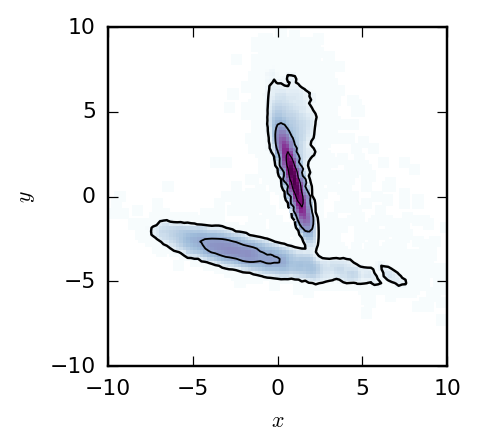

In [138]:
plot_pretty()
clevs = (0.683, 0.955, 0.997) # standard contour levels
plot_2d_dist(x,y,xlim=[-10,10],ylim=[-10,10], nxbins=100, nybins=100, clevs=clevs, smooth=True, xlabel='$x$', ylabel='$y$')

In [158]:
#1600 walkers, n_Steps=10000

cores=np.array([2,4,8,16])

#time =[11.38,8.47,9.862,9.05]
time_individual=[9.48,7.57,6.5,6.3]

#time_1cor = time[0]*2

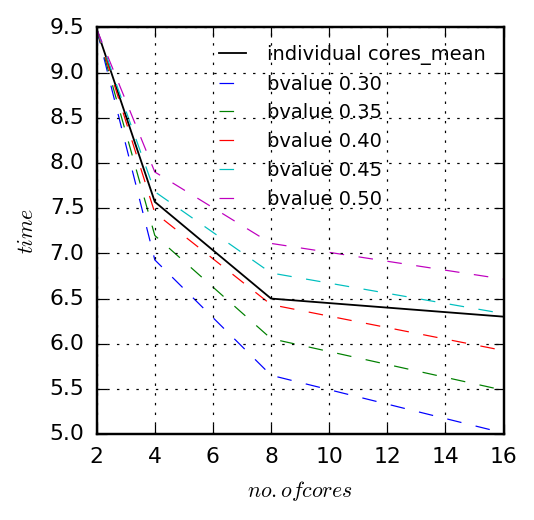

In [165]:
#theor = lambda x: 1/x
amdahl = lambda n,b: n/((b*n)+(1-b))

b = [0.3,0.35,0.4,0.45,0.5]

plot_pretty()
#plt.xscale('log'); plt.yscale('log')
#plt.xlim(t0+1.e-6,tf); plt.ylim(y0+1.e-6,3.)
plt.figure(figsize=(3,3))
plt.xlabel('$no. of cores$'); plt.ylabel('$time$')
#plt.plot(cores,time, lw=1.5, c='slateblue', alpha=1., label='total core time')
plt.plot(cores, time_individual , lw=0.75, c='black', alpha=1., label='individual cores_mean')

for i,bb in enumerate(b):
    
    amdahl = lambda n: n/((bb*n)+(1-bb))
    time_1cor = time_individual[0]*amdahl(2)
    plt.plot(cores,time_1cor/amdahl(cores),'--', lw=0.5, alpha=1., label='bvalue %.2f'%bb)
#plt.xlim(-2,2); plt.ylim(-2,2)
plt.grid()
plt.legend(frameon=False, loc='upper right', fontsize=8)   
plt.show()

My Amdahl factor b is equal to 0.35, that means that 35% of my code is serial, which is a relatively high value. The MCMC with GW stretch moves is working well, as can be seen from the gaussian2d sampling.

### Gelman-Rubin

In [ ]:
def MCMCsample(x, nparams=2, nwalkers=100, nRval=100, modelpdf = None, ipar_active = None, params=[], nsteps=1000000000, Rlim = 1.001):
    """
    MCMC sampler implementing the Goodman & Weare (2010) affine-invariant algorithm
    inner loop is vectorized
    
    run for nsteps or until R_GR=Rlim is reached, whichever comes first
    
    written by Andrey Kravtsov (2014-2016)
    """
    
    try:
        import acor
    except:
        raise Exception("acor package is not installed! do: pip install acor")
        
    # parameters used to draw random number with the GW10 proposal distribution
    ap = 2.0; api = 1.0/ap; asqri=1.0/np.sqrt(ap); afact=(ap-1.0)

    # calculate effective number of parameters if some are specified to be fixed
    ia = (ipar_active==1)
    npareff = np.size(ipar_active[ia])
    print "starting sampling with %d active parameters of the total %d parameters"%(npareff, nparams)
    
    # initialize some auxiliary arrays and variables 
    chain = []; Rval = []; 

    naccept = 0; ntry = 0; nchain = 0
    mw = np.zeros((nwalkers,npareff)); sw = np.zeros((nwalkers,npareff))
    m = np.zeros(npareff); Wgr = np.zeros(npareff); Bgr = np.zeros(npareff); Rgr = np.zeros(npareff)
    
    mutx = []; taux = []
    for i in range(npareff): 
        mutx.append([]); taux.append([])
        Rval.append([])

    gxo = np.zeros((2,nwalkers/2))
    gxo[0,:] = modelpdf(x[0,:,:], params); gxo[1,:] = modelpdf(x[1,:,:], params)
    converged = False;
    while not converged:
        # for parallelization (not implemented here but the MPI version is available)
        # the walkers are split into two complementary sub-groups (see GW10)
        for kd in range(2):
            k = abs(kd-1)
            # vectorized inner loop of walkers stretch move in the Goodman & Weare sampling algorithm
            xchunk = x[k,:,:]
            jcompl = np.random.randint(0,nwalkers/2,nwalkers/2)
            xcompl = x[kd,jcompl,:]
            gxold  = gxo[k,:]
            zf= np.random.rand(nwalkers/2)   # the next few steps implement Goodman & Weare sampling algorithm
            zf = zf * afact; zr = (1.0+zf)*(1.0+zf)*api
            zrtile = np.transpose(np.tile(zr,(nparams,1))) # duplicate zr for nparams
            xtry  = xcompl + zrtile*(xchunk-xcompl)
            gxtry = modelpdf(xtry, params); gx    = gxold 
            gr   = gxtry - gx
            iacc = np.where(gr>0.)
            xchunk[iacc] = xtry[iacc]
            gxold[iacc] = gxtry[iacc]
            aprob = (npareff-1)*np.log(zr) + (gxtry - gx)
            u = np.random.uniform(0.0,1.0,np.shape(xchunk)[0])        
            iprob = np.where(aprob>np.log(u))
            xchunk[iprob] = xtry[iprob]
            gxold[iprob] = gxtry[iprob]
            naccept += len(iprob[0])

            x[k,:,ia] = np.transpose(xchunk[:,ia])
            gxo[k,:] = gxold        
            xdum = x[:,:,ia]

            for i in range(nwalkers/2):
                chain.append(np.array(xdum[k,i,:]))

            for i in range(nwalkers/2):
                mw[k*nwalkers/2+i,:] += xdum[k,i,:]
                sw[k*nwalkers/2+i,:] += xdum[k,i,:]**2
                ntry += 1

        nchain += 1
        
        # compute means for the auto-correlation time estimate
        for i in range(npareff):
            mutx[i].append(np.sum(xdum[:,:,i])/(nwalkers))

        # compute Gelman-Rubin indicator for all parameters
        #if ( nchain >= nwalkers/2 and nchain%nRval == 0):
        if ( nchain%nRval == 0):
            # calculate Gelman & Rubin convergence indicator
            mwc = mw/(nchain-1.0)
            swc = sw/(nchain-1.0)-np.power(mwc,2)

            for i in range(npareff):
                # within chain variance
                Wgr[i] = np.sum(swc[:,i])/nwalkers
                # mean of the means over Nwalkers
                m[i] = np.sum(mwc[:,i])/nwalkers
                # between chain variance
                Bgr[i] = nchain*np.sum(np.power(mwc[:,i]-m[i],2))/(nwalkers-1.0)
                # Gelman-Rubin R factor
                Rgr[i] = (1.0 - 1.0/nchain + Bgr[i]/Wgr[i]/nchain)*(nwalkers+1.0)/nwalkers - (nchain-1.0)/(nchain*nwalkers)
                tacorx = acor.acor(np.abs(mutx[i]))[0]; taux[i].append(np.max(tacorx))
                Rval[i].append(Rgr[i]-1.0)
            print "nchain=",nchain
            print "R values for parameters:", Rgr
            print "tcorr =", np.max(tacorx)
            if (np.max(np.abs(Rgr-1.0)) < np.abs(Rlim-1.0)) or (nchain >= nsteps): converged = True
        
    print "MCMC sampler generated ",ntry," samples using", nwalkers," walkers"
    print "with step acceptance ratio of", 1.0*naccept/ntry
        
    # record integer auto-correlation time at the final iteration
    nthin = int(tacorx)

    return chain, Rval, nthin

def MCMCsample_init(nparams=2, nwalkers=100, x0=None, step=None, ipar_active=None):
    """
    distribute initial positions of walkers in an isotropic Gaussian around the initial point
    """
    np.random.seed()
    
    # in this implementation the walkers are split into 2 subgroups and thus nwalkers must be divisible by 2
    if nwalkers%2:
        raise ValueError("MCMCsample_init: nwalkers must be divisible by 2!")
         
    x = np.zeros([2,nwalkers/2,nparams])

    for i in range(nparams):
        x[:,:,i] = np.reshape(np.random.normal(x0[i],step[i],nwalkers),(2,nwalkers/2))
    ina = (ipar_active==0)
    if np.size(ina) > 0:
        x[:,:,ina] = x0[ina]
    return x

My apologies - I had little time to integrate the GR-convergence indicator into my parallel code, but I do understand the concept, and the steps needed to use an auto-correlation time-based convergence method to check my MCMC code.

### 2. Cosmological constraints from the BAO. (25 points)

In this part of the homework you will use the <a href="http://scholar.harvard.edu/deisenstein/book/baryon-acoustic-oscillations">Baryonic Acoustic Oscillation</a> (BAO) feature in the 2-point correlation function of the Luminous Red Galaxies (LRGs) recently measured in DR11 of the BOSS survey by <a href="http://adsabs.harvard.edu/abs/2014MNRAS.441...24A">Anderson et al. 2014</a> (hereafter A14). You will use the MCMC sampler developed in the HW4 and parallelized above will, as well as the experience in numerically integrating power spectrum to compute theoretical $\Lambda$CDM prediction for $\xi(r)$ that you gained in HW1. 

#### 1. (10 points) Reproducing the BOSS collaboration result.  

If you read the Anderson et al. (2014) paper, you will see that to get their cosmological constraints they do not fit the observed LRG correlation function with a fully self-consistent model $\xi(r)$. Instead, they use model $\xi(r)$ computed for a fiducial cosmology (assumed to be close to the actual cosmology) and simply use it as a template to to measure position of the BAO peak in $r$. At the same time, the information about the shape of $\xi(r)$ measured in observations is essentially ignored, in large part because it is not measured very accurately at these large scales. Your first task is to repeat their procedure. Namely:

* Choose the same fiducial cosmology as in A14 (see their \S 1): $\Omega_{\rm m0}=0.274$, $\Omega_{\Lambda}=1-\Omega_{\rm m0}=0.726$, $h=0.7$, $\Omega_b h^2=0.0224$, $n_s=0.95$, $\sigma_8=0.8$. 
* Compute the model correlation function using eqs 25 and 26 in Anderson et al. with parameters they specified in the text. This is similar to the calculation of the integral in problem 1 of HW3, except that you will be using a function returning approximation of the Eisenstein \& Hu (1998) approximation for the power spectrum instead of the CAMB output.
* Construct the full model correlation function using eq. 27 in A14 using free bias parameter $B^2_{\xi}$ and additive polynomial. These parametrize the unknown bias of the LRG galaxies and effects of the redshift-space distortions and systematic errors in the binned measured correlation function. The correlation function is shifted left and right in $r$ via the ``dilation'' parameter $\alpha$.
* Use your MCMC sampler to sample the posterior pdf of the model parameter $\alpha$ and nuisance parameters $B^2_{\xi}$, $a_1$, $a_2$, $a_3$ defined by the pdf:
$$
\pi(\mathbf{p}\vert\mathbf{d})\propto \exp\left[-\frac{1}{2}(\mathbf{m}-\mathbf{d})^{\rm T}\mathbf{C}^{-1}(\mathbf{m}-\mathbf{d})\right],
$$
where $\mathbf{d}=\{\xi(s_i)\}$ is the measured correlation function vector, $\mathbf{m}=\{\xi_{\rm fit}(s_i)\}$ is the corresponding vector of the model corr. function that depends on parameters $\mathbf{p}=\{\alpha,B_{\xi}^2,a_1,a_2,a_3\}$, $\mathbf{C}$ is the covariance matrix of $\{\xi(s)\}$ measurements (supplied along with   $\{\xi(s_i)\}$).

* Plot and compute posterior distribution of $\alpha$ from your chains and measure its mean value and $68\%$ and $95\% $ confidence limits. 



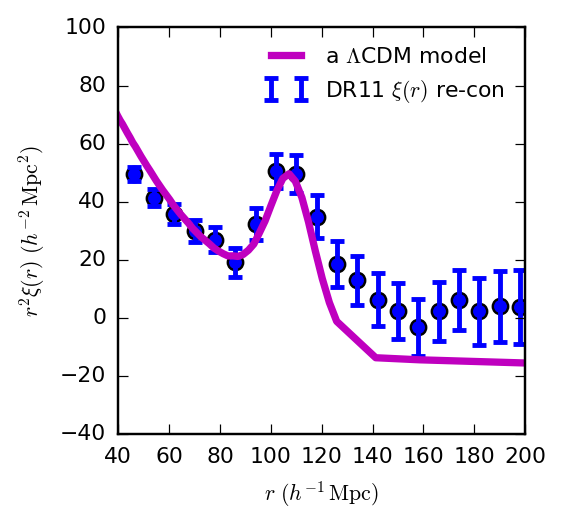

In [26]:
def read_DR11_xi():
    """
    reads DR11 BOSS corr. function for LRG galaxies and corresponding covariance matrix
    returns r, xi vectors and covij = matrix lxl where l=len(r)=len(xi)
    covij[i][j] contains covariance of errors of xi(r_i) and xi(r_j)
    """
    # read in 2-point correlation function and its covariance matrix
    r,xi = np.loadtxt(data_home_dir()+'Anderson_2013_CMASSDR11_corrfunction_x0x2_postrecon.dat',
                      usecols=(0,1), unpack=True)
    ri, rj, covij = np.loadtxt(data_home_dir()+'Anderson_2013_CMASSDR11_corrfunction_cov_x0x2_postrecon.dat',
                               usecols=(0,1,2), unpack=True)

    lmat = np.sqrt(len(ri))
    covij = np.reshape(covij,(lmat,lmat))
    return r, xi, covij


r, xi, covij = read_DR11_xi()    #Important!

xir2 = xi*r*r

# read in theoretical xi(r) computed using integral in HW1
rm, xim = np.loadtxt(data_home_dir()+'xi_out.dat',usecols=(0,1), unpack=True)

ximr2 = xim*rm*rm*2.2 # multiply by arbitrary bias 
exir2 = np.sqrt(np.diagonal(covij))*r*r

#
# plot corr. function along with a model
#
from matplotlib import pyplot as plt
%matplotlib inline
from codes.plot_utils import plot_pretty

plot_pretty()
fig1 = plt.figure(figsize=(3,3))

plt.xlim(40.0,200.0)
plt.errorbar(r, xir2, yerr=exir2, linestyle="None" ,marker="None",ecolor='b',lw=2,capthick=2,label=r'DR11 $\xi(r)$ re-con')
plt.scatter(r, xir2, c='b',s=40)

plt.plot(rm,ximr2, c='m', lw=3.0, label=r'a $\Lambda$CDM model')
#
plt.xlabel(r'$r\ (h^{-1}\rm\, Mpc)$')
plt.ylabel(r'$r^2\xi(r)\ (h^{-2}\,\rm Mpc^2)$')
plt.legend(loc='upper right', frameon=False, fontsize=9)
#
plt.show()


In [27]:
#
# Colossus stuff
#


In [32]:

#Integrand that is used to calculate 2pt-corr
def xi_intlog2(lk, **kwargs):
    k = 10.**lk; x = k * kwargs["R"];
    my_cosmo = kwargs["my_cosmo"]
    cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
    cosmo.interpolation = True
    Pka = cosmo.matterPowerSpectrum(k, 'eh98')
    #print k.min()
    #print k.max()
    return (np.sin(x)/x)*k**3*Pka*np.exp(-(k**2))


In [33]:
#Splining the colossus xi



def xi_r(r, my_cosmo):
    lk = np.arange(-3,3,0.001)
    kwargs = {"R":r, "my_cosmo":my_cosmo}
    integrand = xi_intlog2(lk, **kwargs)
    sp = UnivariateSpline(lk,integrand,s=0)
    integral = sp.integral(lk.min(),lk.max())
    return integral


def xi_total(r, my_cosmo=None):
    if not my_cosmo: my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.274, 'Ob0': 0.0224, 'sigma8': 0.8, 'ns': 0.95}
    # cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
    # cosmo.interpolation = True
    # print 'get xi: ', cosmo.OL(0), cosmo.Om(0), cosmo.h
    
    xi_my = np.zeros_like(r)
    for i, rd in enumerate(r):
        xi_my[i] = xi_r(rd, my_cosmo)
    return xi_my

In [34]:


'''

def xi_intlog2_1(lk, **kwargs):
    k = 10.**lk
    x = k * kwargs["R"]
    cosmo = kwargs["cosmo"]
    Pka = cosmo.matterPowerSpectrum(k, 'eh98')
    a = 1 # h^-1 Mpc
    return (np.sin(x)/x)*k**3*Pka*np.exp(-k**2 * a**2)

def xi_r(r, cosmo):
    lk = np.arange(-3,3,0.001)
    # lk = np.arange(lkmin,lkmax,0.001)
    kwargs = {"R":r, "cosmo":cosmo}
    integrand = xi_intlog2(lk, **kwargs)
    sp = UnivariateSpline(lk,integrand,s=0)
    integral = sp.integral(lk.min(),lk.max())
    return integral

def xi_total(r, my_cosmo=None):
    if not my_cosmo: my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.274, 'Ob0': 0.0224, 'sigma8': 0.8, 'ns': 0.95}
    cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
    cosmo.interpolation = True

    xi_my = np.zeros_like(r)
    for i, rd in enumerate(r):
        xi_my[i] = xi_r(rd, cosmo)
    return xi_my
    
'''

'\n\ndef xi_intlog2_1(lk, **kwargs):\n    k = 10.**lk\n    x = k * kwargs["R"]\n    cosmo = kwargs["cosmo"]\n    Pka = cosmo.matterPowerSpectrum(k, \'eh98\')\n    a = 1 # h^-1 Mpc\n    return (np.sin(x)/x)*k**3*Pka*np.exp(-k**2 * a**2)\n\ndef xi_r(r, cosmo):\n    lk = np.arange(-3,3,0.001)\n    # lk = np.arange(lkmin,lkmax,0.001)\n    kwargs = {"R":r, "cosmo":cosmo}\n    integrand = xi_intlog2(lk, **kwargs)\n    sp = UnivariateSpline(lk,integrand,s=0)\n    integral = sp.integral(lk.min(),lk.max())\n    return integral\n\ndef xi_total(r, my_cosmo=None):\n    if not my_cosmo: my_cosmo = {\'flat\': True, \'H0\': 70.0, \'Om0\': 0.274, \'Ob0\': 0.0224, \'sigma8\': 0.8, \'ns\': 0.95}\n    cosmo = cosmology.setCosmology(\'my_cosmo\', my_cosmo)\n    cosmo.interpolation = True\n\n    xi_my = np.zeros_like(r)\n    for i, rd in enumerate(r):\n        xi_my[i] = xi_r(rd, cosmo)\n    return xi_my\n    \n'

In [35]:
#my_cosmo = { 'H0': 70.0, 'Om0': 0.274,'OL0': 0.726, 'Ob0': 0.0224, 'sigma8': 0.8, 'ns': 0.95}
#z = 0.0
#cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
#cosmo.interpolation = True

r, xi, covij = read_DR11_xi()    #Important!

xi_mine = xi_total(r)   #Set of all xi values corresponding to the data R-list

In [36]:
xi_sp = UnivariateSpline(r,xi_mine,s=0)
print r
print xi_sp(r)

[  46.   54.   62.   70.   78.   86.   94.  102.  110.  118.  126.  134.
  142.  150.  158.  166.  174.  182.  190.  198.]
[ 0.07645376  0.04201831  0.02343881  0.01306546  0.00719647  0.00400741
  0.00266511  0.0027255   0.00330395  0.00286406  0.00109261 -0.00061048
 -0.00146127 -0.001666   -0.00159005 -0.00143828 -0.00128915 -0.00116143
 -0.00105505 -0.00096315]


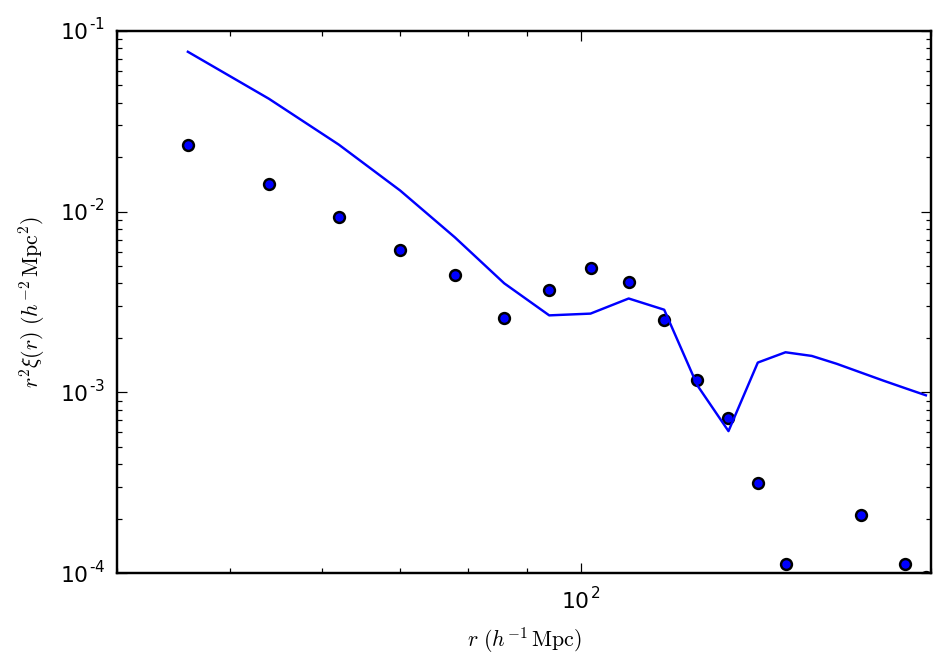

In [37]:
plt.plot(r,np.abs(xi_sp(r)))
plt.scatter(r,xi)
plt.xscale('log')
plt.yscale('log')
plt.xlim(40,200)
plt.ylim(10**-4,10**-1)
plt.xlabel(r'$r\ (h^{-1}\rm\, Mpc)$')
plt.ylabel(r'$r^2\xi(r)\ (h^{-2}\,\rm Mpc^2)$')

In [67]:
def xi_func(x,r):
    alpha=x[0]
    b2 = x[1]
    a1=x[2]
    a2=x[3]
    a3=x[4]   
    a_xi = a1/(r**2) + a2/(r) + a3
    model = b2*xi_sp(alpha*r) + a_xi
    return model

In [68]:
# likelihood for computing BAO constraints
# xd = shape = (nwalkers, nparams) - vector of walkers and parameters
# xi_func = routine computing xi(r) for model parameters in the vector xd,
# xi - observed xi(r),
# covinv = inverse covariance matrix
# the function returns ln(L), so make sure your MCMC sampler works with ln(L) or, if not, get rid of logging
def modelpdf(xd):
    nw = np.shape(xd)[1]
    dummy = np.zeros(nw)
    
    r, xi, covij = read_DR11_xi() 
    
    covinv = np.linalg.inv(covij)
    
    for i in range(nw):
        xidm = xi_func(xd[:,i],r) - xi
        dummy[i] = -0.5*np.dot(xidm.T,np.dot(covinv,xidm))
        #dummy[i] += parameter_priors(xd[i,:])
    return dummy

In [69]:
#
#Goodman-Weare '10 MCMC for sampling a Gaussian
#
n = 1000
step = [0.01,0.01,0.01,0.01,0.01]   #For both dimensions
num_walkers = 512
nparams = 5

x0 = np.zeros((2,num_walkers//2,nparams))
xstart = [1,1,1,1,0.1]

for i in range(2):
    for k in range(num_walkers//2):
        for m in range(nparams):
            x0[i,k,m] = rnd.normal(xstart[m],scale=step[m])


nsample = 0; i = 0; k = 0; kd=0 


In [70]:
x = np.copy(x0)

xfinal = []
nwalkers = num_walkers

tstart = clock()
for nsample in range(n):
    #print x
    for kd in [0,1]:
        k = abs(kd-1)
        
        l = rnd.randint(0,nwalkers//2,nwalkers//2)
        G = rnd.uniform(0,1,nwalkers//2)   
        zr = ((G+1)/np.sqrt(2))**2
        
        target = x[k][l]
        xtry = target + (zr*(x[kd]-target).T).T
        
        gxtry = modelpdf(xtry.T)
        gx = modelpdf(x[kd].T)
        u = rnd.uniform(0,1)
        
        #print gxtry.shape
        #print gx.shape
        #print zr.shape
        
        aprob = gxtry - gx + (nparams-1)*np.log10(zr)
        i_acc=np.where(aprob>np.log10(u)) 
        x[kd][i_acc]=xtry[i_acc]
        xfinal.append(np.copy(x[kd]))

print "GW10 for Gaussian completed in %.2f seconds"%(clock()-tstart)
    

GW10 for Gaussian completed in 57.95 seconds


In [71]:
xfinal = np.asarray(xfinal)

alpha=xfinal[:,:,0].flatten()
b2=xfinal[:,:,1].flatten()
a1=xfinal[:,:,2].flatten()
a2=xfinal[:,:,3].flatten()
a3=xfinal[:,:,4].flatten()

print xfinal.shape

(2000, 256, 5)


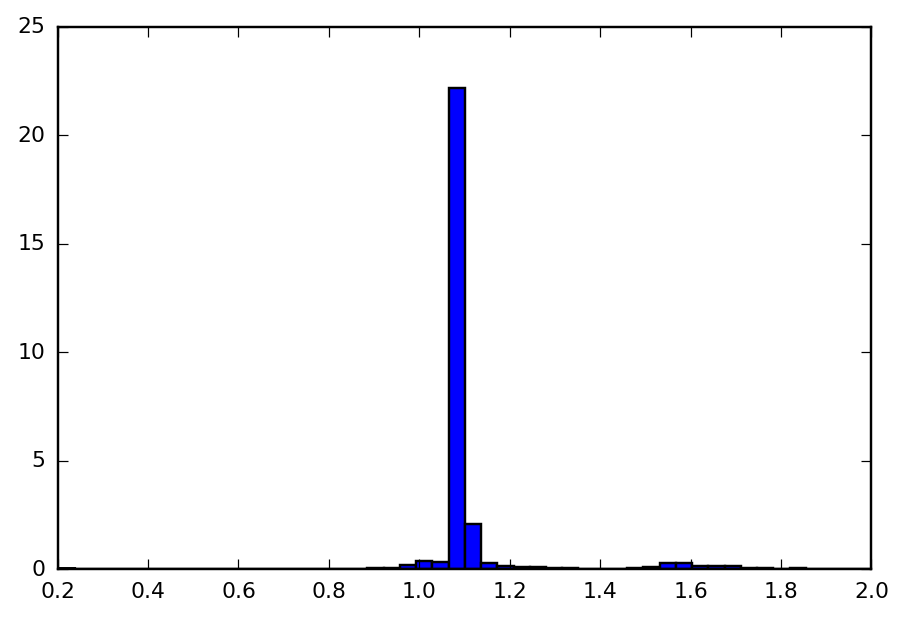

In [72]:
plt.hist(alpha,bins = 50, normed=True)
plt.show()


In [73]:
print alpha.mean()
print b2.mean()
print a1.mean()
print a2.mean()
print a3.mean()

1.11457580477
0.583595606613
-75.8412903733
1.66383360195
-0.00470363925904


In [74]:
alpha68= np.percentile(alpha,68)
alpha95= np.percentile(alpha,95)
alpha32= np.percentile(alpha,32)
alpha5= np.percentile(alpha,5)

print alpha68
print alpha95
print alpha32
print alpha5

1.09196193439
1.50774467876
1.08191655807
1.06691270675


I am getting meaningful results for alpha, which is close to the expected value. On having a conversation with my colleague Nora Shipp, I realise that the problem is in the convergence of my MCMC code - with the given set of walkers and number of steps, my code isnt converging. I test that with the following:

1. I get a different value of alpha and the other nuisance parameters every time i run it.

2. On changing the initial step, as well as the size of the steps for all parameters, I get slightly different values, hinting towards a lack of convergence. I do know that the physical value is close to what i printed here i.e. 1.091.

#### 2. (15 points). Fitting correlation function with self-consistent model $\xi(r)$.

Repeat the fitting of observed correlation function in the task 1, but instead of using template $\xi(r)$ and dilation parameter $\alpha$, compute model correlation function for varying $\Omega_\Lambda$, $h$, and  $\Omega_{\rm m0}$, while keeping the nuisance parameters fixed to the best fit values from calculation above and keeping other cosmological parameters fixed. Use colossus and the EH98 approximation to $P(k)$ to compute the model $\xi_{\rm fit}(s)$ for each of the sampled cosmological parameter combinations, as we did in HW1. Plot results in the form of constraints in $H_0-\Omega_{\rm m}$ and $\Omega_\Lambda-\Omega_{\rm m}$ planes.

Obtain constraint on $\Omega_{\rm m0}$ from your chains and translate it into $\alpha$ and compare it to the result in the first task. Note that you can find expressions for the drag redshift and sound horizon at $z_{\rm drag}$ in eqs  2-4 in <a href="http://adsabs.harvard.edu/abs/1999ApJ...511....5E">Eisenstein & Hu 1999.</a>

Below is a code snippet that reads observed correlation function and its covariance matrix and a theoretical $\Lambda$CDM function and compares them in a plot.

In [102]:
my_cosmo = { 'H0': 70.0, 'Om0': 0.274,'OL0': 1-0.274, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
z = 0.0
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
cosmo.interpolation = False

r, xi, covij = read_DR11_xi()    #Important!

xi = xi_total(r,my_cosmo)   #Set of all xi values corresponding to the data R-list

In [103]:
def xi_func(x,r):
    b2 = 1.01
    a1=1.03
    a2=1.02
    a3=0.01   
    a_xi = a1/r**2 + a2/r + a3
    
    my_cosmo = { 'H0': 100*x[2], 'Om0': x[1],'OL0': x[0], 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
    #cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
    #cosmo.interpolation = False
    xi = xi_total(r,my_cosmo)   #Set of all xi values corresponding to the data R-list
    
    #print my_cosmo
    
    model = b2*xi + a_xi
    return model

def parameter_priors(x):
    OL0 = x[0]
    Om0 = x[1]
    h0 = x[2]
    
    #Normalization - uniform priors
    Lnorm = 1/(1-0.1)
    Mnorm = 1/(1-0.1)
    h0norm = 1/(1-0.5)
    
    pL =0
    pM =0
    ph =0
    
    if OL0<1 and OL0>0.1:
        pL = Lnorm
    if Om0<1 and Om0>0.1:
        pM = Mnorm
    if h0<1 and h0>0.5:
        ph = h0norm
        
    if pL*pM*ph == 0:
        return -1000
    else:
        return np.log(pL*pM*ph)


def modelpdf(xd):
    nw = np.shape(xd)[1]
    dummy = np.zeros(nw)
    
    r, xi, covij = read_DR11_xi() 
    
    covinv = np.linalg.inv(covij)
    
    for i in range(nw):
        
        prior = parameter_priors(xd[:,i])
        
        if prior<=-500:
            continue
        xidm = xi_func(xd[:,i],r) - xi
        dummy[i] = -0.5*np.dot(xidm.T,np.dot(covinv,xidm))
        dummy[i] += prior 
    
    return dummy

In [116]:
#
#Goodman-Weare '10 MCMC for sampling a Gaussian
#
n = 10000 
step = [0.1,0.1,0.1]   #For both dimensions
num_walkers = 512
nparams = 3

x0 = np.zeros((2,num_walkers//2,nparams))
xstart = [0.7,0.3,0.6]

for i in range(2):
    for k in range(num_walkers//2):
        for m in range(nparams):
            x0[i,k,m] = rnd.normal(xstart[m],scale=step[m])


nsample = 0; i = 0; k = 0 

In [117]:
x = np.copy(x0)

xfinal = []
nwalkers = num_walkers

tstart = clock()
for nsample in range(n):
    #print x
    for kd in [0,1]:
        k = abs(kd-1)
        
        l = rnd.randint(0,nwalkers//2,nwalkers//2)
        G = rnd.uniform(0,1,nwalkers//2)   
        zr = ((G+1)/np.sqrt(2))**2
        
        target = x[k][l]
        xtry = target + (zr*(x[kd]-target).T).T
        
        gxtry = modelpdf(xtry.T)
        gx = modelpdf(x[kd].T)
        u = rnd.uniform(0,1)
        
        #print gxtry.shape
        #print gx.shape
        #print zr.shape
        
        aprob = gxtry - gx + (nparams-1)*np.log10(zr)
        i_acc=np.where(aprob>np.log10(u)) 
        x[kd][i_acc]=xtry[i_acc]
        xfinal.append(np.copy(x[kd]))

print "GW10 for Gaussian completed in %.2f seconds"%(clock()-tstart)
    

GW10 for Gaussian completed in 547.40 seconds


In [118]:
xfinal = np.asarray(xfinal)

omegaL=xfinal[:,:,0].flatten()
omegaM=xfinal[:,:,1].flatten()
hubble=xfinal[:,:,2].flatten()


print xfinal.shape

(20000, 256, 3)


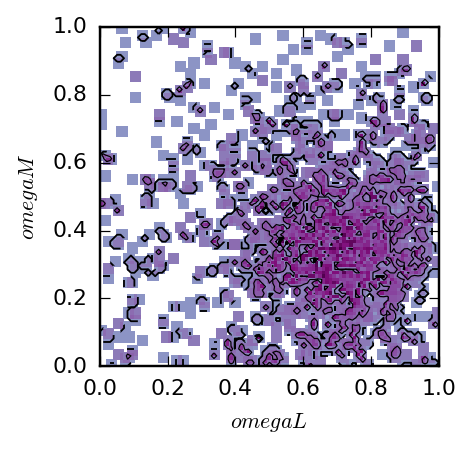

In [119]:
plot_pretty()
clevs = (0.683, 0.955, 0.997) # standard contour levels
plot_2d_dist(omegaL,omegaM,xlim=[0,1],ylim=[0,1], nxbins=100, nybins=100, clevs=clevs, smooth=True, xlabel='$omegaL$', ylabel='$omegaM$')

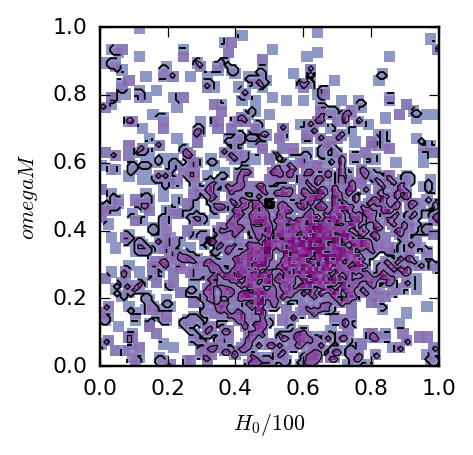

In [123]:
plot_pretty()
clevs = (0.683, 0.955, 0.997) # standard contour levels
plot_2d_dist(hubble,omegaM,xlim=[0,1],ylim=[0,1], nxbins=100, nybins=100, clevs=clevs, smooth=True, xlabel='$H_0/100$', ylabel='$omegaM$')

In [125]:
h_new=hubble[(hubble>0) & (hubble<1)]
m_new=omegaM[(omegaM>0) & (omegaM<1)]
L_new=omegaL[(omegaL>0) & (omegaL<1)]

print h_new.mean()
print m_new.mean()
print L_new.mean()

0.542993766844
0.403362940825
0.621912119884


In [126]:
my_cosmo = { 'H0': 70.0, 'Om0': 0.274,'OL0': 0.726, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
z = 0.3
# set my_cosmo to be the current cosmology	
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
cosmo.interpolation = False
D_a = cosmo.angularDiameterDistance(z)
r_dfid = cosmo.soundHorizon()
D_vfid = np.power(2.99792458E10*z*(1.0+z)*(1.0+z)*D_a*D_a/(cosmo.H0*cosmo.Ez(z)),1.0/3.0)
rdDvfid = r_dfid/D_vfid

In [127]:
my_cosmo2 = { 'H0': h_new.mean(), 'Om0': m_new.mean(),'OL0': L_new.mean(), 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
z = 0.3
# set my_cosmo to be the current cosmology	
cosmo2 = cosmology.setCosmology('my_cosmo', my_cosmo2)
cosmo2.interpolation = False
D_a = cosmo2.angularDiameterDistance(z)
r_d = cosmo2.soundHorizon()
D_v = np.power(2.99792458E10*z*(1.0+z)*(1.0+z)*D_a*D_a/(cosmo2.H0*cosmo2.Ez(z)),1.0/3.0)
rdDv = r_d/D_v

In [76]:
alphanew = rdDvfid/rdDv

NameError: name 'rdDvfid' is not defined

In [75]:
print alphanew
print alpha.mean()

NameError: name 'alphanew' is not defined

My best fit cosmology is slightly different from the usual LCDM parameter values we come across in the current age, which translates to different correlation functions and hence different alphas, physically.